# Deep learning - convolution neural net

A simple demonstration of deep learning using a convolutional neural net (CNN) to classify images.

For most practical applications we would ideally use a pre-trained CNN with a proven good performance and just do some fine tuning for our specific task. However, I'm going to build a simple CNN from scratch for learning purposes.

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
import numpy as np
import math
import matplotlib.pyplot as plt

print('Tensorflow', tf.__version__)

Tensorflow 2.1.0


## Load data
We're going to use the [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset, citation:

> Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms. Han Xiao, Kashif Rasul, Roland Vollgraf. arXiv:1708.07747

In [2]:
data = fashion_mnist
(x_train, y_train), (x_test, y_test) = data.load_data()
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


We have 60,000 train examples and 10,000 test examples, each a 28x28 image.

Class labels (`y_*`) are
```
0	T-shirt/top
1	Trouser
2	Pullover
3	Dress
4	Coat
5	Sandal
6	Shirt
7	Sneaker
8	Bag
9	Ankle boot
```

In [3]:
labels_dict = {0:'T-shirt/top',
               1:'Trouser',
               2:'Pullover',
               3:'Dress',
               4:'Coat',
               5:'Sandal',
               6:'Shirt',
               7:'Sneaker',
               8:'Bag',
               9:'Ankle boot'}

## Display some data

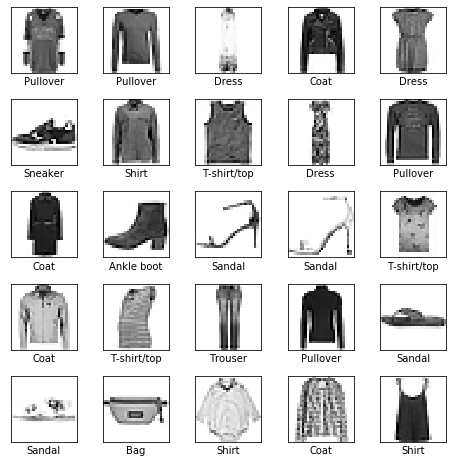

In [4]:
# Display some random, labelled images
n_train = x_train.shape[0] # number of training examples
n_images = 25 # number of images to display
display_rows = math.floor(math.sqrt(n_images))
display_cols = math.ceil(n_images / display_rows)

# Select n_images random images
rand_sel = np.random.randint(low=0, high=n_train, size=n_images)

plt.figure(figsize=(8, 8))
for i in range(n_images):
    image = x_train[rand_sel[i]]
    plt.subplot(display_rows, display_cols, i+1)
    plt.imshow(image, cmap='Greys')
    plt.xlabel(labels_dict[y_train[rand_sel[i]]])
    plt.xticks([])
    plt.yticks([])
plt.subplots_adjust(hspace=0.4)
plt.show()

## Process data

We need to normalise the pixel values.

In [5]:
max_val = np.max(x_train)
print(max_val)
x_train = x_train / max_val
x_test = x_test / max_val
print(np.max(x_train))

255
1.0


We also need to add a depth channel to the data. `keras.layers.Conv2D()` expects the depth of the image to be specified - e.g. for a 3-channel colour image of 28x28 pixels it expects input of the form (28x28x3), for a greyscale image it expects (28x28x1). Right now our images are of shape (28x28), so we need to add the extra (x1) on the end.

In [6]:
print(x_train.shape)
x_train = x_train[:, :, :, np.newaxis]
x_test = x_test[:, :, :, np.newaxis]
print(x_train.shape)

(60000, 28, 28)
(60000, 28, 28, 1)


## Define neural net

In [7]:
image_shape = x_train.shape[1:] # (28, 28, 1)
n_classes = len(set(y_train)) # 10

In [8]:
model = Sequential([
    Conv2D(filters=16, kernel_size=(3,3), strides=(1, 1),
           padding='same', activation='relu', input_shape=image_shape),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(filters=32, kernel_size=(3,3), strides=(1, 1),
           padding='same', activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Flatten(),
    Dense(units=64, activation='relu'),
    Dense(units=n_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                100416    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                6

**Explanation of the model summary:**
* The first element in `Output Shape` is the batch size. We're not using batches, hence we get `None` (https://stackoverflow.com/a/47241264).


* `conv2d` has 16 filters, each 3x3x1 in size (last dimension, depth==1, is because our input is greyscale; if we were using colour images we'd need a 3x3x3 filter for the three colour channels). So we have a `16*3*3*1` parameters, plus one bias parameter for each filter, for a total of `16*3*3*1+16=160` parameters.


* `conv2d_1` has 32 filters, each 3x3x16 in size (last dimension, depth==16, is because our input is the output of the `max_pooling2d` layer, which has a depth of 16).  So we have a `32*3*3*16` parameters, plus one bias parameter for each filter, for a total of `32*3*3*16+32=4640` parameters (see [here](https://cs231n.github.io/convolutional-networks/) for a good explanation of CNN paramater calculation, and CNNs in general).


* For the dense layers, it's just `(input+1)*units`, e.g. `(1568+1)*64 = 100416`, `(64+1)*10 = 650`, where the `+1` is for the bias.

In [9]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

## Train

In [10]:
model.fit(x_train, y_train, epochs=10, verbose=1, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 38s 626us/sample - loss: 0.4353 - accuracy: 0.8450 - val_loss: 0.3633 - val_accuracy: 0.8715
Epoch 2/10
60000/60000 [==============================] - 39s 646us/sample - loss: 0.3032 - accuracy: 0.8920 - val_loss: 0.3260 - val_accuracy: 0.8825
Epoch 3/10
60000/60000 [==============================] - 37s 610us/sample - loss: 0.2638 - accuracy: 0.9049 - val_loss: 0.2823 - val_accuracy: 0.8966
Epoch 4/10
60000/60000 [==============================] - 37s 619us/sample - loss: 0.2364 - accuracy: 0.9134 - val_loss: 0.2755 - val_accuracy: 0.8996
Epoch 5/10
60000/60000 [==============================] - 35s 583us/sample - loss: 0.2117 - accuracy: 0.9213 - val_loss: 0.2605 - val_accuracy: 0.9081
Epoch 6/10
60000/60000 [==============================] - 33s 555us/sample - loss: 0.1947 - accuracy: 0.9284 - val_loss: 0.2691 - val_accuracy: 0.9063
Epoch 7/10
60000/60000 [====================